In [3]:

import scipy
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
#from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
from PIL import Image
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2 Physical GPUs, 2 Logical GPUs


In [2]:
import subprocess

def get_gpu_memory():
    """Get available GPU memory."""
    result = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,noheader,nounits"]
    )
    # Split the result by newline and get the first value
    gpu_memory_str = result.decode().strip().split('\n')[0]
    return int(gpu_memory_str)

# Get GPU memory in MB
gpu_memory = get_gpu_memory()
print("Available GPU memory:", gpu_memory, "MB")


Available GPU memory: 23542 MB


In [3]:
# def define_discriminator(input_shape=(1024, 1024, 3)):
#     model = Sequential()
#     # Convolutional layers
#     model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))

#     # model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))

#     model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))

#     # Flatten layer
#     model.add(Flatten())
#     # Output layer
#     model.add(Dense(1, activation='sigmoid'))
#     opt = Adam(lr=0.0002, beta_1=0.5)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#     return model

# test_discriminator = define_discriminator()
# print(test_discriminator.summary())


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def define_discriminator(input_shape=(256, 256, 3)):
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Flatten layer
    model.add(Flatten())
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

test_discriminator = define_discriminator()
print(test_discriminator.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       7

/home/titan/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.initializers import RandomNormal

def define_generator(latent_dim):
    model = Sequential()
    # We will reshape input latent vector into 16x16 image as a starting point.
    n_nodes = 256 * 16 * 16  # 65536 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim))  # Dense layer to work with 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))  # Reshape to 16x16x256
    
    # Upsample to 32x32
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02)))  # 32x32x128
    model.add(LeakyReLU(alpha=0.2))
    
    # Upsample to 64x64
    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02)))  # 64x64x64
    model.add(LeakyReLU(alpha=0.2))
    
    # # Upsample to 128x128
    # model.add(Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02)))  # 128x128x32
    # model.add(LeakyReLU(alpha=0.2))
    
    # Upsample to 256x256
    model.add(Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02)))  # 256x256x16
    model.add(LeakyReLU(alpha=0.2))
    
    # # Upsample to 512x512
    # model.add(Conv2DTranspose(4, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02)))  # 512x512x8
    # model.add(LeakyReLU(alpha=0.2))

    # Upsample to 1024x1024
    model.add(Conv2DTranspose(3, (2, 2), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02), activation='tanh'))  # 1024x1024x3
    
    return model
model = load_model(r'/media/titan/My Book/Pratham/generated_512/epoch75.h5')


test_gen = define_generator(100)
print(test_gen.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 65536)             6619136   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       262208    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                            

In [6]:

# def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
# 	model = Sequential()
# 	# We will reshape input latent vector into 8x8 image as a starting point. 
#     #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
#     #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
# 	n_nodes = 128 * 8 * 8  #8192 nodes
# 	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
# 	model.add(LeakyReLU(alpha=0.2))
# 	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
# 	# upsample to 16x16
# 	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
# 	model.add(LeakyReLU(alpha=0.2))
# 	# upsample to 32x32
# 	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
# 	model.add(LeakyReLU(alpha=0.2))
# 	# generate
# 	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
# 	return model  #Model not compiled as it is not directly trained like the discriminator.
#                     #Generator is trained via GAN combined model. 

# test_gen = define_generator(100)
# print(test_gen.summary())


In [7]:

# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [8]:
# from tqdm import tqdm as tqdm_progress
# import os
# import cv2
# import numpy as np
# def load_data(folder, max_images=2500):
#     images = []
#     count = 0
#     for filename in tqdm_progress(os.listdir(folder)):
#         if count >= max_images:
#             break
#         img = cv2.imread(os.path.join(folder, filename))
#         img = cv2.resize(img, (256,256))
#         if img is not None:
#             images.append(img)
#             count += 1
#     return np.array(images)

# X_train=load_data(r"/media/titan/My Book/Pratham/yolo_dir/train/images")

# with open('X_train_256.pkl', 'wb') as f:
#     pickle.dump(X_train, f)

In [9]:

# Load x_train from the .pkl file
def load_real_samples():
    with open('X_train_256.pkl', 'rb') as f:
        X = pickle.load(f)

    X =(X- 127.5) / 127.5 
    return X
    

In [10]:
# X=load_real_samples()

In [11]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Assume X is your array of images with shape (num_samples, height, width, channels)
# # X should be preprocessed (e.g., scaled to [0, 1]) before passing to the generator

# # Define data generator for training data
# train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

# # Create a generator from the array of images
# train_generator = train_datagen.flow(
#     x=X,                           # Array of images
#     batch_size=32,         # Batch size
#     shuffle=True                   # Shuffle the data
# )

# # Now, you can use train_generator in your model.fit() function.


In [12]:
#def generate_real_samples(train_generator, n_samples):
    # X_real = next(train_generator)
    # return X_real



def generate_real_samples(train_generator, n_samples):
	# choose random images
	ix = randint(0, train_generator.shape[0], n_samples)
	# select the random images and assign it to X
	X = train_generator[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


In [13]:

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y


In [14]:
# # train the generator and discriminator
# #We loop through a number of epochs to train our Discriminator by first selecting
# #a random batch of images from our true/real dataset.
# #Then, generating a set of images using the generator. 
# #Feed both set of images into the Discriminator. 
# #Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

# def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=32):
# 	bat_per_epo = int(dataset.shape[0] / n_batch)
# 	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
#                             #and a half batch of fake samples, combined a single batch. 
# 	# manually enumerate epochs and bacthes. 
# 	for i in range(n_epochs):
# 		# enumerate batches over the training set
# 		for j in range(bat_per_epo):
            
#             # Train the discriminator on real and fake images, separately (half batch each)
#         #Research showed that separate training is more effective. 
# 			# get randomly selected 'real' samples
# 			X_real, y_real = generate_real_samples(dataset, half_batch)
# 			# update discriminator model weights
#             ##train_on_batch allows you to update weights based on a collection 
#             #of samples you provide
#             #Let us just capture loss and ignore accuracy value (2nd output below)
# 			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
#             # generate 'fake' examples
# 			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
# 			# update discriminator model weights
# 			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
#             #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
# 			# prepare points in latent space as input for the generator
# 			X_gan = generate_latent_points(latent_dim, n_batch)
             
#             # The generator wants the discriminator to label the generated samples
#         # as valid (ones)
#         #This is where the generator is trying to trick discriminator into believing
#         #the generated image is true (hence value of 1 for y)			
# 			y_gan = ones((n_batch, 1))
            
#             # Generator is part of combined model where it got directly linked with the discriminator
#         # Train the generator with latent_dim as x and 1 as y. 
#         # Again, 1 as the output as it is adversarial and if generator did a great
#         #job of folling the discriminator then the output would be 1 (true)
# 			# update the generator via the discriminator's error
# 			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
#             # Print losses on this batch
# 			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
# 				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
        
# 	g_model.save('cifar_generator_2epochs.h5')
#     print("saved")
    
     

In [15]:
def save_imgs(epoch):
    # load model
    #model = load_model(r"C:\Users\upratham\GAN\cifar_generator_2epochs.h5") #Model trained for 100 epochs
    # generate images
    latent_points = generate_latent_points(100, 4)  #Latent dim and n_samples
    # generate images
    X = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0

    import numpy as np
    X = (X*255).astype(np.uint8)

    # plot the result
    #show_plot(X, 5)
    #X.shape
    img=X[1]

    # Convert the NumPy array to a PIL Image
    img = Image.fromarray(img)

    # Save the image as a PNG file

    # Save the image as a PNG file
    img.save("/media/titan/My Book/Pratham/generated_256/GCP_%d.png" % epoch)
    
    return



In [16]:
import numpy as np

def train(g_model, d_model, gan_model, train_generator, latent_dim, n_epochs=100, n_batch=32,save_interval=250):
    bat_per_epo = int(2500 / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            print(j)
            # Train the discriminator on real and fake images, separately (half batch each)
            X_real, y_real = generate_real_samples(train_generator, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # Train the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
            
        if i % save_interval == 0:
            g_model.save("/media/titan/My Book/Pratham/generated_256/new_epoch%d.h5"%i)
            save_imgs(epoch=i)
        
    g_model.save('/media/titan/My Book/Pratham/generated_256/new_last_epoch.h5')
    print("Model saved")



In [ ]:


###################################################################
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
# generator = define_generator(latent_dim)

generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
train_generator = load_real_samples()
# train model
train(generator, discriminator, gan_model, train_generator, latent_dim,save_interval=50, n_epochs=25000, n_batch=128,)

################################################################################

0


2024-02-17 00:33:16.014670: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-02-17 00:33:16.488544: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 1/19, d1=0.728, d2=0.695 g=0.693
1
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 2/19, d1=0.117, d2=0.693 g=0.695
2
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 3/19, d1=0.032, d2=0.690 g=0.699
3
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 4/19, d1=0.015, d2=0.686 g=0.704
4
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 5/19, d1=0.008, d2=0.681 g=0.710
5
2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch 6/19, d1=0.006, d2=0.674 g=0.719
6
2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch 7/19, d1=0.004, d2=0.665 g=0.732
7
2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch 8/19, d1=0.003, d2=0.651 g=0.750
8
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 9/19, d1=0.003, d2=0.632 g=0.779
9
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 10/19, d1=0.002, d2=0.604

In [ ]:
import tensorflow as tf

# List all physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    # If there are GPUs, print information about each GPU
    for gpu in physical_devices:
        print("GPU:", gpu)
else:
    print("No GPUs available")


2024-02-21 14:34:27.217972: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 1/79 [..............................] - ETA: 3:34

2024-02-21 14:34:28.339768: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 3s 5ms/step


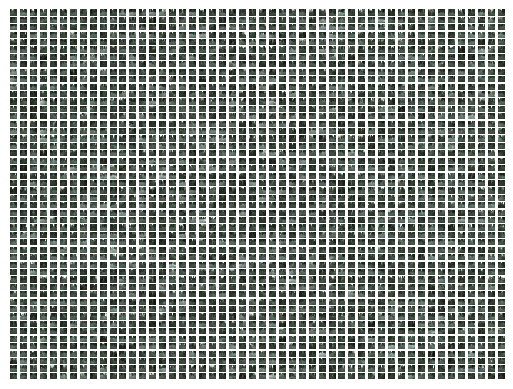

In [5]:

#def generate_real_samples(train_generator, n_samples):
    # X_real = next(train_generator)
    # return X_real



def generate_real_samples(train_generator, n_samples):
	# choose random images
	ix = randint(0, 10, 10)
	# select the random images and assign it to X
	X = train_generator[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model(r'/media/titan/My Book/Pratham/generated_256/model.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 2500)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 50)


#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck




In [6]:
for i in range(50):
	img=X[i]
	img = Image.fromarray(img)
	img.save("generated_256/epoch18500_%d.png" % i)
	print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
for i in range(78):
    print(i)